In [1]:
import torch
from lightning_datasets import CIFAR10
import pytorch_lightning as L
from torch import nn
from torchmetrics import Accuracy, MeanMetric
from pytorch_lightning.loggers import MLFlowLogger
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.transforms import v2
import PIL
from pytorch_lightning.callbacks import ModelCheckpoint

In [2]:
class ResidualBlock(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, use1x1conv: bool = False, stride: int = 1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels,
                               kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(
            out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)
        self.downsample_layer = None
        self.downsample_bn = None
        if use1x1conv:
            self.downsample_layer = nn.Conv2d(
                in_channels, out_channels*self.expansion, kernel_size=1, stride=stride, padding=0)
            self.downsample_bn = nn.BatchNorm2d(out_channels*self.expansion)

        self.relu = nn.ReLU()

    def forward(self, X):
        identity = X.clone()
        X = self.conv1(X)
        X = self.bn1(X)
        X = self.relu(X)
        X = self.conv2(X)
        X = self.bn2(X)
        X = self.relu(X)
        X = self.conv3(X)
        X = self.bn3(X)

        if self.downsample_layer != None:
            identity = self.downsample_layer(identity)
            identity = self.downsample_bn(identity)

        X += identity
        X = self.relu(X)

        return X

In [3]:
class ResNet50(L.LightningModule):
    def __init__(self, out_features: int, lr=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            ResNet50.__make_layer(64, 64, 3),
            ResNet50.__make_layer(
                64*ResidualBlock.expansion, 128, 4, stride=2),
            ResNet50.__make_layer(
                128*ResidualBlock.expansion, 256, 6, stride=2),
            ResNet50.__make_layer(
                256*ResidualBlock.expansion, 512, 3, stride=2),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512*ResidualBlock.expansion, out_features)
        )
        self.loss = nn.CrossEntropyLoss()
        self.lr = lr
        self.accuracy = Accuracy(task='multiclass', num_classes=out_features)
        self.train_loss = MeanMetric()

        self.net.apply(ResNet50.__init_layers)

    def __init_layers(layer):
        if isinstance(layer, nn.Conv2d):
            nn.init.kaiming_uniform_(layer.weight, 0.1)
        if isinstance(layer, nn.Linear):
            nn.init.kaiming_normal_(layer.weight, 0.1)

    def __make_layer(in_channels, out_channels, num_residual_blocks, stride=1):
        layers = []

        if stride != 1 or in_channels != out_channels * ResidualBlock.expansion:
            layers.append(ResidualBlock(
                in_channels, out_channels, True, stride=stride))
        else:
            layers.append(ResidualBlock(in_channels, out_channels))

        in_channels = out_channels*ResidualBlock.expansion

        for i in range(num_residual_blocks-1):
            layers.append(ResidualBlock(in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, X):
        return self.net(X)

    def training_step(self, batch, batch_idx):
        loss, output, y = self.__common_step(batch, batch_idx)
        self.accuracy(output, y)
        self.train_loss(loss)
        self.log_dict({"training_loss": self.train_loss,
                      "training_acc": self.accuracy})
        return loss

    def validation_step(self, batch, batch_idx):
        loss, output, y = self.__common_step(batch, batch_idx)
        self.accuracy(output, y)
        self.train_loss(loss)
        self.log_dict({"validation_loss": self.train_loss,
                      "validation_acc": self.accuracy})
        return loss

    def test_step(self, batch, batch_idx):
        loss, output, y = self.__common_step(batch, batch_idx)
        self.accuracy(output, y)
        self.train_loss(loss)
        self.log_dict({"test_loss": self.train_loss,
                      "test_acc": self.accuracy})
        return loss

    def on_train_epoch_end(self):
        self.log("global_step", self.global_step)

    def __common_step(self, batch, batch_idx):
        X, y = batch
        output = self(X)
        loss = self.loss(output, y)
        return loss, output, y

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr)

In [4]:
model = ResNet50(10)
dataset = CIFAR10("./data", batch_size=128, image_size=(224,
                  224), image_augumentation=True, num_workers=16)

callbacks = [ModelCheckpoint("./saved_checkpoints/resnet50-cifar10/",
                             save_top_k=5, monitor="global_step", mode='max', every_n_epochs=1)]

logger = MLFlowLogger(run_name="ResNet50-CIFAR10")
trainer = L.Trainer('gpu', logger=logger, max_epochs=10,
                    callbacks=callbacks, log_every_n_steps=30)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [5]:
trainer.fit(model, dataset)

You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti SUPER') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
f:\code\deep-learning\.venv\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory F:\code\deep-learning\lab\saved_checkpoints\resnet50-cifar10 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params | Mode 
----------------------------------------------------------
0 | net        | Sequential         | 23.6 M | train
1 | loss       | CrossEntropyLoss   | 0      | train
2 | accuracy   | MulticlassAccuracy | 0      | train
3 | train_loss | MeanMetric         | 0      | train
------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


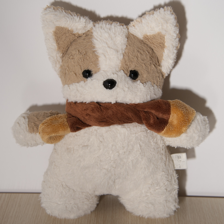

In [14]:
transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, True),
        v2.Resize((224, 224))
    ])
image = PIL.Image.open('images/DSC03691.jpg')
image = image.resize((224, 224))
test_data = transform(image).reshape(1,3,224,224)
image

In [15]:
model.to('cpu')
model.eval()
predict_label = dataset.validation_dataset.classes[torch.argmax(model(test_data))]
f"Classes: {predict_label}"

'Classes: cat'